Table of contents
1. [Precinct Shapefile](#shapefile)
2. [Election Results](#electionresults)
3. [Joining Election Results to Precinct Shapefile](#joining)
4. [Comparison to VEST](#comparison)

**Import Python Packages**

In [199]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geopandas as gp
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

<a name="shapefile"></a>


# Precinct Shapefile

## Load VEST's Final File

In [200]:
vest_shp = gp.read_file("./raw-from-source/az_2018/az_2018.shp")

In [201]:
vest_shp.shape

(1489, 27)

In [202]:
vest_shp.head(1)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G18USSRMCS,G18USSDSIN,G18USSGGRE,G18USSOWRI,G18GOVRDUC,G18GOVDGAR,G18GOVGTOR,...,G18TRERYEE,G18TREDMAN,G18TREOWRI,G18SPIRRIG,G18SPIDHOF,G18SPIOWRI,G18MNIRHAR,G18MNIDPIE,G18MNIOWRI,geometry
0,AP0002,ALPINE,AP,202,81,7,0,231,55,3,...,209,68,1,192,88,1,210,68,0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


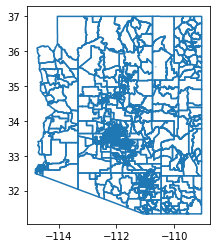

In [203]:
vest_shp.boundary.plot()

## Load Source Precinct File

VEST does not specify their source. This file is from Kaggle, it is the same one MGGG used

In [204]:
precincts = gp.read_file("./raw-from-source/az_vtd_2018_v2/az_vtd_2018_new_pima.shp")

In [205]:
precincts.shape

(1496, 6)

In [206]:
precincts.head(1)

,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry
0,AP0002,ALPINE,AP,NaN,NaN,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


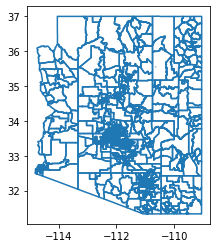

In [207]:
precincts.boundary.plot()

## Seeing if Kaggle File is the same

Outer join the VEST's file and the raw precinct file on `pctnum`

In [208]:
vest_kaggle_joined = pd.merge(vest_shp,precincts,
                              left_on=['PCTNUM'],right_on=['pctnum'],
                              how='outer',indicator=True)

In [209]:
vest_kaggle_joined.groupby('_merge').count()

,PCTNUM,PRECINCTNA,CDE_COUNTY,G18USSRMCS,G18USSDSIN,G18USSGGRE,G18USSOWRI,G18GOVRDUC,G18GOVDGAR,G18GOVGTOR,...,G18MNIRHAR,G18MNIDPIE,G18MNIOWRI,geometry_x,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,7,7,0,0,7
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,249,249,1489


In [210]:
#Want to check this in the "both" match as well as the shapefile match
first_check = vest_kaggle_joined[(vest_kaggle_joined["_merge"]=="both")]

pdv_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_y')
vest_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_x')

pdv_shapes_elections_and_shapes.crs=vest_shapes_elections_and_shapes.crs

In [211]:
pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,
                                                   decimal=1).value_counts()

True     1486
False       3
dtype: int64

So of the 1,489 precincts that join, only 3 have different geometries - which makes sense, because there are 3 precincts that had merges with others. Confirm it is these 3 precincts: 

In [212]:
s = pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,
                                                       decimal=1)
s[s != True]

1486    False
1487    False
1488    False
dtype: bool

In [213]:
first_check.loc[[1486,1487,1488]]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G18USSRMCS,G18USSDSIN,G18USSGGRE,G18USSOWRI,G18GOVRDUC,G18GOVDGAR,G18GOVGTOR,...,G18MNIDPIE,G18MNIOWRI,geometry_x,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry_y,_merge
1486,LP0056,WENDEN,LP,61.0,33.0,4.0,1.0,75.0,19.0,3.0,...,24.0,2.0,"POLYGON ((-113.33337 33.99992, -113.33375 33.9...",LP0056,WENDEN,LP,NaN,NaN,"POLYGON ((-113.38486 33.88291, -113.38476 33.8...",both
1487,MC0614,SOUTH MTN PARK,MC,62.0,121.0,1.0,1.0,78.0,105.0,2.0,...,107.0,0.0,"POLYGON ((-111.99720 33.34877, -111.99720 33.3...",MC0614,SOUTH MTN PARK,MC,NaN,NaN,"POLYGON ((-111.99720 33.34877, -112.04884 33.3...",both
1488,AP0048,PUERCO E/W,AP,202.0,481.0,51.0,4.0,282.0,432.0,27.0,...,518.0,1.0,"POLYGON ((-109.68663 35.16998, -109.68659 35.1...",AP0048,PUERCO EAST,AP,NaN,NaN,"POLYGON ((-109.52628 34.96131, -109.52631 34.9...",both


Yes - these are the 3 precincts that were merged that have different geographies. So the Kaggle shapefile is the same one that VEST is using. 

## Merging Precincts

Try to create a gdf that has the new precincts we want, then concat and remove the old ones. 

### Puerco East/West Merge

From VEST documentation: 
> Apache: Merge Puerco East/West

In [214]:
puerco = precincts[(precincts['cde_county'] == 'AP') & \
                   (precincts['precinctna'].str.contains('PUERCO'))].copy()
puerco

,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry
294,AP0048,PUERCO EAST,AP,NaN,NaN,"POLYGON ((-109.52628 34.96131, -109.52631 34.9..."
295,AP0049,PUERCO WEST,AP,NaN,NaN,"POLYGON ((-109.78982 34.82213, -109.78976 34.8..."


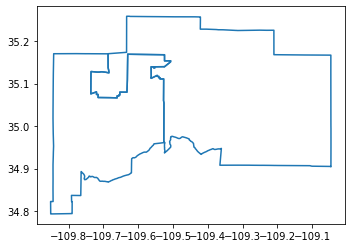

In [215]:
puerco.boundary.plot()

Could try fixing this with buffer zero

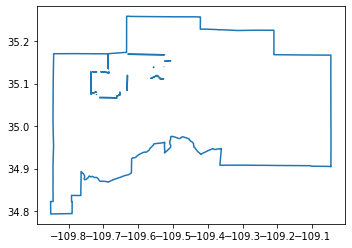

In [216]:
puerco_dissolved = puerco.dissolve(by='cde_county')
puerco_dissolved.boundary.plot()

Looks kind of weird, compare to VEST's merged Puerco

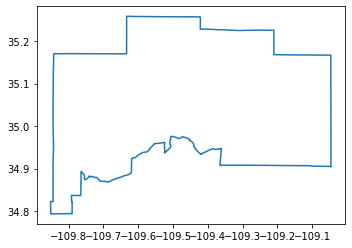

In [217]:
vest_shp[(vest_shp['CDE_COUNTY'] == 'AP') & \
                   (vest_shp['PRECINCTNA'].str.contains('PUERCO'))].boundary.plot()

Ok, not sure how to make this fix in geopandas, so going to just sub in the VEST Puerco precinct to the other one. 

In [218]:
precincts.head(1)

,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry
0,AP0002,ALPINE,AP,NaN,NaN,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


Remove `DIST_CON` and `DIST_LEG` fields from Kaggle precinct shapefile because they aren't in VEST's final file. 

In [219]:
precincts.drop(columns=['DIST_CON','DIST_LEG'], inplace = True)

Create a temp df that has VEST's Puerco precinct

In [220]:
temp = vest_shp[(vest_shp['CDE_COUNTY'] == 'AP') & \
                   (vest_shp['PRECINCTNA'].str.contains('PUERCO'))][['PCTNUM','PRECINCTNA',
                                                                     'CDE_COUNTY','geometry']]
temp.columns = temp.columns.str.lower()

Concatenate the VEST merged Puerco precinct with the Kaggle precincts shapefile

In [221]:
precincts = pd.concat([precincts,temp])

Drop the two original Puerco precincts E/W

In [222]:
precincts[(precincts['cde_county'] == 'AP') & \
                   (precincts['precinctna'].str.contains('PUERCO'))]

,pctnum,precinctna,cde_county,geometry
294,AP0048,PUERCO EAST,AP,"POLYGON ((-109.52628 34.96131, -109.52631 34.9..."
295,AP0049,PUERCO WEST,AP,"POLYGON ((-109.78982 34.82213, -109.78976 34.8..."
1488,AP0048,PUERCO E/W,AP,"POLYGON ((-109.68663 35.16998, -109.68659 35.1..."


In [223]:
precincts.drop([294,295], inplace = True)

In [224]:
precincts[(precincts['cde_county'] == 'AP') & \
                   (precincts['precinctna'].str.contains('PUERCO'))]

,pctnum,precinctna,cde_county,geometry
1488,AP0048,PUERCO E/W,AP,"POLYGON ((-109.68663 35.16998, -109.68659 35.1..."


### Wenden Merge

From VEST's documentation: 
> La Paz: Merge Alamo into Wenden

In [225]:
wenden = precincts[(precincts['cde_county'] == 'LP') & \
                   ((precincts['precinctna'].str.contains('Alamo') | \
                     precincts['precinctna'].str.contains('WENDEN')))].copy()
wenden

,pctnum,precinctna,cde_county,geometry
110,LP0063,Alamo,LP,"POLYGON ((-113.33337 33.99992, -113.33375 33.9..."
362,LP0056,WENDEN,LP,"POLYGON ((-113.38486 33.88291, -113.38476 33.8..."


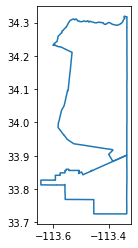

In [226]:
wenden.boundary.plot()

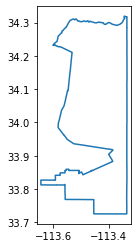

In [227]:
wenden_dissolved = wenden.dissolve(by='cde_county')
wenden_dissolved.boundary.plot()

Compare to VEST's wenden precinct

In [228]:
vest_shp[(vest_shp['CDE_COUNTY'] == 'LP') & \
                   (vest_shp['PRECINCTNA'].str.contains('WENDEN'))]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G18USSRMCS,G18USSDSIN,G18USSGGRE,G18USSOWRI,G18GOVRDUC,G18GOVDGAR,G18GOVGTOR,...,G18TRERYEE,G18TREDMAN,G18TREOWRI,G18SPIRRIG,G18SPIDHOF,G18SPIOWRI,G18MNIRHAR,G18MNIDPIE,G18MNIOWRI,geometry
1486,LP0056,WENDEN,LP,61,33,4,1,75,19,3,...,72,20,2,67,28,2,69,24,2,"POLYGON ((-113.33337 33.99992, -113.33375 33.9..."


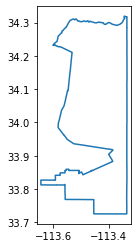

In [229]:
vest_shp[(vest_shp['CDE_COUNTY'] == 'LP') & \
                   (vest_shp['PRECINCTNA'].str.contains('WENDEN'))].boundary.plot()

Looks the same, so going to sub it in again

In [230]:
wenden_dissolved.reset_index(inplace = True)

In [231]:
wenden_dissolved = wenden_dissolved[['pctnum','precinctna','cde_county','geometry']]

In [232]:
wenden_dissolved

,pctnum,precinctna,cde_county,geometry
0,LP0063,Alamo,LP,"POLYGON ((-113.33383 33.90172, -113.33383 33.9..."


In [233]:
wenden_dissolved.loc[0,'pctnum'] = 'LP0056'

In [234]:
wenden_dissolved.loc[0,'precinctna'] = 'WENDEN'

In [235]:
wenden_dissolved

,pctnum,precinctna,cde_county,geometry
0,LP0056,WENDEN,LP,"POLYGON ((-113.33383 33.90172, -113.33383 33.9..."


In [236]:
precincts[(precincts['cde_county'] == 'LP') & \
                   ((precincts['precinctna'].str.contains('Alamo') | \
                     precincts['precinctna'].str.contains('WENDEN')))]

,pctnum,precinctna,cde_county,geometry
110,LP0063,Alamo,LP,"POLYGON ((-113.33337 33.99992, -113.33375 33.9..."
362,LP0056,WENDEN,LP,"POLYGON ((-113.38486 33.88291, -113.38476 33.8..."


In [237]:
precincts.drop([110,362], inplace = True)

In [238]:
precincts = pd.concat([precincts,wenden_dissolved])

In [239]:
precincts[(precincts['cde_county'] == 'LP') & \
                   ((precincts['precinctna'].str.contains('Alamo') | \
                     precincts['precinctna'].str.contains('WENDEN')))]

,pctnum,precinctna,cde_county,geometry
0,LP0056,WENDEN,LP,"POLYGON ((-113.33383 33.90172, -113.33383 33.9..."


### Maricopa Merge

From VEST's documentation: 
> Maricopa: South Mtn Park E, NE, S, SE, SW merged into South Mtn Park


In [240]:
maricopa = precincts[(precincts['cde_county'] == 'MC') & \
                   ((precincts['precinctna'].str.contains('SOUTH MTN PARK')))].copy()
maricopa

,pctnum,precinctna,cde_county,geometry
1140,MC0614,SOUTH MTN PARK,MC,"POLYGON ((-111.99720 33.34877, -112.04884 33.3..."
1235,MC0619,SOUTH MTN PARK SW,MC,"POLYGON ((-112.10045 33.30506, -112.10160 33.3..."
1236,MC0618,SOUTH MTN PARK SOUTH,MC,"POLYGON ((-112.04911 33.31961, -112.05412 33.3..."
1237,MC0617,SOUTH MTN PARK SE,MC,"POLYGON ((-112.04913 33.33418, -112.01801 33.3..."
1238,MC0616,SOUTH MTN PARK NE,MC,"POLYGON ((-111.99716 33.35244, -111.99703 33.3..."
1239,MC0615,SOUTH MTN PARK EAST,MC,"POLYGON ((-112.04913 33.33418, -112.04916 33.3..."


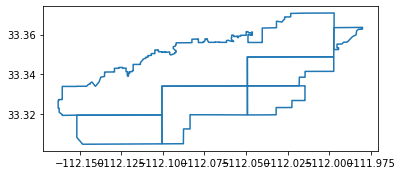

In [241]:
maricopa.boundary.plot()

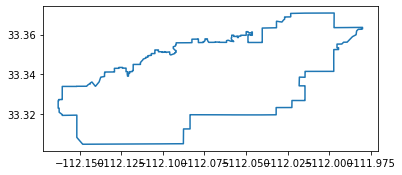

In [242]:
maricopa_dissolved = maricopa.dissolve(by='cde_county')
maricopa_dissolved.boundary.plot()

In [243]:
vest_shp[(vest_shp['CDE_COUNTY'] == 'MC') & \
                   (vest_shp['PRECINCTNA'].str.contains('SOUTH MTN PARK'))]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G18USSRMCS,G18USSDSIN,G18USSGGRE,G18USSOWRI,G18GOVRDUC,G18GOVDGAR,G18GOVGTOR,...,G18TRERYEE,G18TREDMAN,G18TREOWRI,G18SPIRRIG,G18SPIDHOF,G18SPIOWRI,G18MNIRHAR,G18MNIDPIE,G18MNIOWRI,geometry
1487,MC0614,SOUTH MTN PARK,MC,62,121,1,1,78,105,2,...,75,103,0,63,114,1,65,107,0,"POLYGON ((-111.99720 33.34877, -111.99720 33.3..."


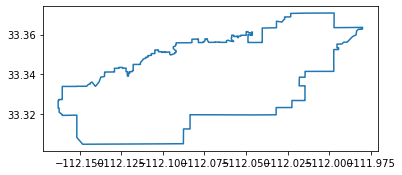

In [244]:
vest_shp[(vest_shp['CDE_COUNTY'] == 'MC') & \
                   (vest_shp['PRECINCTNA'].str.contains('SOUTH MTN PARK'))].boundary.plot()

Looks the same, so going to sub it in again

In [245]:
maricopa_dissolved

,geometry,pctnum,precinctna
cde_county,,,
MC,"POLYGON ((-112.10045 33.30506, -112.10160 33.3...",MC0614,SOUTH MTN PARK


In [246]:
maricopa_dissolved.reset_index(inplace = True)

In [247]:
maricopa_dissolved = maricopa_dissolved[['pctnum','precinctna','cde_county','geometry']]
maricopa_dissolved

,pctnum,precinctna,cde_county,geometry
0,MC0614,SOUTH MTN PARK,MC,"POLYGON ((-112.10045 33.30506, -112.10160 33.3..."


In [248]:
precincts[(precincts['cde_county'] == 'MC') & \
                   ((precincts['precinctna'].str.contains('SOUTH MTN PARK')))]

,pctnum,precinctna,cde_county,geometry
1140,MC0614,SOUTH MTN PARK,MC,"POLYGON ((-111.99720 33.34877, -112.04884 33.3..."
1235,MC0619,SOUTH MTN PARK SW,MC,"POLYGON ((-112.10045 33.30506, -112.10160 33.3..."
1236,MC0618,SOUTH MTN PARK SOUTH,MC,"POLYGON ((-112.04911 33.31961, -112.05412 33.3..."
1237,MC0617,SOUTH MTN PARK SE,MC,"POLYGON ((-112.04913 33.33418, -112.01801 33.3..."
1238,MC0616,SOUTH MTN PARK NE,MC,"POLYGON ((-111.99716 33.35244, -111.99703 33.3..."
1239,MC0615,SOUTH MTN PARK EAST,MC,"POLYGON ((-112.04913 33.33418, -112.04916 33.3..."


In [249]:
drop_rows = precincts[(precincts['cde_county'] == 'MC') & \
                   ((precincts['precinctna'].str.contains('SOUTH MTN PARK')))].index.values.tolist()
drop_rows

[1140, 1235, 1236, 1237, 1238, 1239]

In [250]:
precincts.drop(drop_rows, inplace = True)

In [251]:
precincts = pd.concat([precincts,maricopa_dissolved])

In [252]:
precincts[(precincts['cde_county'] == 'MC') & \
                   ((precincts['precinctna'].str.contains('SOUTH MTN PARK')))]

,pctnum,precinctna,cde_county,geometry
0,MC0614,SOUTH MTN PARK,MC,"POLYGON ((-112.10045 33.30506, -112.10160 33.3..."


### Check New Shapefile

In [253]:
precincts.shape

(1489, 4)

In [254]:
vest_shp.shape

(1489, 27)

In [255]:
vest_kaggle_joined = pd.merge(vest_shp,precincts,
                              left_on=['PCTNUM'],right_on=['pctnum'],
                              how='outer',indicator=True)

In [256]:
vest_kaggle_joined.groupby('_merge')[['geometry_x','geometry_y']].count()

,geometry_x,geometry_y
_merge,,
left_only,0,0
right_only,0,0
both,1489,1489


In [257]:
#Want to check this in the "both" match as well as the shapefile match
first_check = vest_kaggle_joined[(vest_kaggle_joined["_merge"]=="both")]

pdv_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_y')
vest_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_x')

pdv_shapes_elections_and_shapes.crs=vest_shapes_elections_and_shapes.crs

In [258]:
pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,
                                                   decimal=1).value_counts()

True     1487
False       2
dtype: int64

In [259]:
s = pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,
                                                       decimal=1)
s[s != True]

1486    False
1487    False
dtype: bool

In [260]:
first_check.loc[[1486,1487]][['PCTNUM','PRECINCTNA','geometry_x','geometry_y']]

,PCTNUM,PRECINCTNA,geometry_x,geometry_y
1486,LP0056,WENDEN,"POLYGON ((-113.33337 33.99992, -113.33375 33.9...","POLYGON ((-113.33383 33.90172, -113.33383 33.9..."
1487,MC0614,SOUTH MTN PARK,"POLYGON ((-111.99720 33.34877, -111.99720 33.3...","POLYGON ((-112.10045 33.30506, -112.10160 33.3..."


So there's small differences still in these two precinct geometries, but it seems fine - probably just because of differences between geopandas vs GIS merging. 

<a name="electionresults"></a>

# Election Results


## Reading in MEDSL Results

The SOS results are by county and would require quite a bit of processing to load all of them, so going to just try to use MEDSL results and see how close that gets. 

In [261]:
medsl = pd.read_csv('./raw-from-source/precinct_2018.csv', encoding='ISO-8859-1', low_memory = False) 

In [262]:
az_elections = medsl[medsl['state_fips'] == 4].copy()

In [263]:
az_elections.to_csv('./raw-from-source/medsl_az_2018.csv')

To figure out the names of the offices that we need in MEDSL's file: 

In [264]:
# with pd.option_context("display.max_rows", 1000):
#     display(az_elections.groupby(['office']).sum())

In [265]:
az_elections[az_elections.office.isin(['Attorney General',
                                      'US Senate',
                                      'Governor',
                                      'Secretary Of State',
                                      'State Treasurer',
                                      'Superintendent Of Public Instruction',
                                      'State Mine Inspector'])]\
    .groupby(['office','party','candidate']).sum()['votes']

office                                party        candidate        
Attorney General                      democrat     January Contreras    1120726
                                      nonpartisan  [Write-in]              1792
                                      republican   Mark Brnovich        1201398
Governor                              democrat     David Garcia          994341
                                      green        Angel Torres           50962
                                      nonpartisan  [Write-in]              1268
                                      republican   Doug Ducey           1330863
Secretary Of State                    democrat     Katie Hobbs          1176384
                                      nonpartisan  [Write-in]              1243
                                      republican   Steve Gaynor         1156132
State Mine Inspector                  democrat     William Pierce       1090346
                                      nonpartisan  

In [266]:
az_elections = az_elections[az_elections.office.isin(['Attorney General',
                                      'US Senate',
                                      'Governor',
                                      'Secretary Of State',
                                      'State Treasurer',
                                      'Superintendent Of Public Instruction',
                                      'State Mine Inspector'])].copy()

In [267]:
az_elections.loc[(az_elections.candidate == '[Write-in]') & (az_elections.office == 'US Senate')]['votes'].sum()

1521

So the write-in in MEDSL is less than what it should be. 

The write-in candidates were listed as party nonpartisan in the MEDSL results

In [268]:
az_elections[(az_elections.office == 'US Senate') & ( (~az_elections.party.isin(['democrat','green','republican','write_in'])))]

,precinct,office,party,mode,votes,jurisdiction,county,candidate,district,dataverse,year,stage,state,special,writein,state_po,state_fips,state_cen,state_ic
397953,ALPINE 02.1-02.7,US Senate,nonpartisan,total,0,Apache,Apache,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
397954,CANYON DE CHELLY 03.1,US Senate,nonpartisan,total,0,Apache,Apache,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
397955,CHINLE 05.1,US Senate,nonpartisan,total,2,Apache,Apache,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
397956,CONCHO,US Senate,nonpartisan,total,4,Apache,Apache,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
397957,CORNFIELDS 10.1 SD20,US Senate,nonpartisan,total,0,Apache,Apache,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405730,10 BISON,US Senate,nonpartisan,total,1,Navajo,Navajo,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
405734,11 MOGOLLON,US Senate,nonpartisan,total,2,Navajo,Navajo,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
405738,12 WOODLAND,US Senate,nonpartisan,total,0,Navajo,Navajo,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61
405742,13 SITGREAVES,US Senate,nonpartisan,total,7,Navajo,Navajo,[Write-in],statewide,senate,2018,gen,Arizona,False,True,AZ,4,86,61


In [269]:
az_elections.loc[az_elections['candidate'] == "[Write-in]", 'party'] = 'write_in'

In [270]:
az_elections.head(1)

,precinct,office,party,mode,votes,jurisdiction,county,candidate,district,dataverse,year,stage,state,special,writein,state_po,state_fips,state_cen,state_ic
221142,0128 COMSTOCK,Attorney General,republican,total,627,Maricopa,Maricopa,Mark Brnovich,statewide,state,2018,gen,Arizona,False,False,AZ,4,86,61


## Pivoting MEDSL Election Results

Pivot the table by county and precinct

In [271]:
az_elections_pivot = az_elections.pivot_table(index = ['county','precinct'],
                         columns = ['office','party'],
                        values = ['votes'],
                         aggfunc = 'sum')

Testing out dataset, investigating

In [272]:
az_elections_pivot.reset_index(inplace = True)

In [273]:
az_elections_pivot.columns = ['_'.join(filter(None, col)).replace(' ','_').replace('votes_','').lower() \
     for col in az_elections_pivot.columns]

In [274]:
az_elections_pivot.head(3)

,county,precinct,attorney_general_democrat,attorney_general_republican,attorney_general_write_in,governor_democrat,governor_green,governor_republican,governor_write_in,secretary_of_state_democrat,...,state_treasurer_democrat,state_treasurer_republican,state_treasurer_write_in,superintendent_of_public_instruction_democrat,superintendent_of_public_instruction_republican,superintendent_of_public_instruction_write_in,us_senate_democrat,us_senate_green,us_senate_republican,us_senate_write_in
0,Apache,ALPINE 02.1-02.7,69.0,214.0,2.0,55.0,3.0,231.0,1.0,79.0,...,68.0,209.0,1.0,88.0,192.0,1.0,81.0,7.0,202.0,0.0
1,Apache,CANYON DE CHELLY 03.1,1333.0,236.0,4.0,1251.0,75.0,253.0,3.0,1387.0,...,1297.0,264.0,6.0,1378.0,198.0,1.0,1292.0,68.0,217.0,0.0
2,Apache,CHINLE 05.1,606.0,140.0,2.0,591.0,39.0,121.0,1.0,645.0,...,602.0,138.0,1.0,628.0,113.0,3.0,601.0,39.0,112.0,2.0


In [275]:
az_elections_pivot.columns

Index(['county', 'precinct', 'attorney_general_democrat',
       'attorney_general_republican', 'attorney_general_write_in',
       'governor_democrat', 'governor_green', 'governor_republican',
       'governor_write_in', 'secretary_of_state_democrat',
       'secretary_of_state_republican', 'secretary_of_state_write_in',
       'state_mine_inspector_democrat', 'state_mine_inspector_republican',
       'state_mine_inspector_write_in', 'state_treasurer_democrat',
       'state_treasurer_republican', 'state_treasurer_write_in',
       'superintendent_of_public_instruction_democrat',
       'superintendent_of_public_instruction_republican',
       'superintendent_of_public_instruction_write_in', 'us_senate_democrat',
       'us_senate_green', 'us_senate_republican', 'us_senate_write_in'],
      dtype='object')

In [276]:
az_elections_pivot.columns = [col.replace('attorney_general',
             'atg').replace('governor',
             'gov').replace('secretary_of_state',
             'sos').replace('state_treasurer',
             'tre').replace('state_mine_inspector',
             'mni').replace('superintendent_of_public_instruction',
             'spi').replace('us_senate',
             'uss').replace('democrat',
             'd').replace('republican',
             'r').replace('green',
             'g').replace('write_in',
             'w') for col in az_elections_pivot.columns]

In [277]:
az_elections_pivot.head()

,county,precinct,atg_d,atg_r,atg_w,gov_d,gov_g,gov_r,gov_w,sos_d,...,tre_d,tre_r,tre_w,spi_d,spi_r,spi_w,uss_d,uss_g,uss_r,uss_w
0,Apache,ALPINE 02.1-02.7,69.0,214.0,2.0,55.0,3.0,231.0,1.0,79.0,...,68.0,209.0,1.0,88.0,192.0,1.0,81.0,7.0,202.0,0.0
1,Apache,CANYON DE CHELLY 03.1,1333.0,236.0,4.0,1251.0,75.0,253.0,3.0,1387.0,...,1297.0,264.0,6.0,1378.0,198.0,1.0,1292.0,68.0,217.0,0.0
2,Apache,CHINLE 05.1,606.0,140.0,2.0,591.0,39.0,121.0,1.0,645.0,...,602.0,138.0,1.0,628.0,113.0,3.0,601.0,39.0,112.0,2.0
3,Apache,CONCHO,283.0,1029.0,6.0,210.0,24.0,1103.0,6.0,302.0,...,267.0,1050.0,4.0,304.0,1003.0,4.0,298.0,38.0,1002.0,4.0
4,Apache,CORNFIELDS 10.1 SD20,308.0,54.0,0.0,292.0,5.0,67.0,0.0,313.0,...,311.0,51.0,0.0,325.0,38.0,0.0,314.0,10.0,46.0,0.0


In [278]:
az_elections_pivot.sum().astype(str)

county      ApacheApacheApacheApacheApacheApacheApacheApac...
precinct    ALPINE 02.1-02.7CANYON DE CHELLY 03.1CHINLE 05...
atg_d                                               1120726.0
atg_r                                               1201398.0
atg_w                                                  1792.0
gov_d                                                994341.0
gov_g                                                 50962.0
gov_r                                               1330863.0
gov_w                                                  1268.0
sos_d                                               1176384.0
sos_r                                               1156132.0
sos_w                                                  1243.0
mni_d                                               1090346.0
mni_r                                               1168798.0
mni_w                                                  1214.0
tre_d                                               1052197.0
tre_r   

Re-order the MEDSL columns in the pivot table to match VEST's ordering

In [279]:
az_elections_pivot = az_elections_pivot[['county', 'precinct', 
 'uss_r', 'uss_d', 'uss_g', 'uss_w',
 'gov_r', 'gov_d', 'gov_g', 'gov_w', 
 'sos_r', 'sos_d', 'sos_w', 
 'atg_r', 'atg_d', 'atg_w', 
 'tre_r', 'tre_d', 'tre_w', 
 'spi_r', 'spi_d', 'spi_w', 
 'mni_r', 'mni_d', 'mni_w']]

Compare the totals from the MEDSL results to VEST's:

In [280]:
vest_cols = [col for col in vest_shp.columns if 'G18' in col]
medsl_cols = [col for col in az_elections_pivot.columns if col != 'county' and col != 'precinct']

print('vest sum\t\t rdh sum\tnot equal')
print('-----------------------------------------------------')
for v, m in zip(vest_cols, medsl_cols):
    if vest_shp[v].sum() != int(az_elections_pivot[m].sum()):
        print(v, vest_shp[v].sum(), '\t', m, int(az_elections_pivot[m].sum()), '\t***')
    else:
        print(v, vest_shp[v].sum(), '\t', m, int(az_elections_pivot[m].sum()))

vest sum		 rdh sum	not equal
-----------------------------------------------------
G18USSRMCS 1135200 	 uss_r 1135200
G18USSDSIN 1191100 	 uss_d 1191100
G18USSGGRE 57442 	 uss_g 57442
G18USSOWRI 3801 	 uss_w 1521 	***
G18GOVRDUC 1330863 	 gov_r 1330863
G18GOVDGAR 994341 	 gov_d 994341
G18GOVGTOR 50962 	 gov_g 50962
G18GOVOWRI 3203 	 gov_w 1268 	***
G18SOSRGAY 1156132 	 sos_r 1156132
G18SOSDHOB 1176384 	 sos_d 1176384
G18SOSOWRI 2953 	 sos_w 1243 	***
G18ATGRBRN 1201398 	 atg_r 1201398
G18ATGDCON 1120726 	 atg_d 1120726
G18ATGOWRI 4243 	 atg_w 1792 	***
G18TRERYEE 1249120 	 tre_r 1249120
G18TREDMAN 1052197 	 tre_d 1052197
G18TREOWRI 2517 	 tre_w 1056 	***
G18SPIRRIG 1113781 	 spi_r 1113781
G18SPIDHOF 1185457 	 spi_d 1185457
G18SPIOWRI 3638 	 spi_w 1373 	***
G18MNIRHAR 1168798 	 mni_r 1168798
G18MNIDPIE 1090346 	 mni_d 1090346
G18MNIOWRI 3444 	 mni_w 1214 	***


In [281]:
vest_shp[['PCTNUM','PRECINCTNA','CDE_COUNTY','G18USSOWRI']].sample(5)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G18USSOWRI
438,SC0004,Nogales 4,SC,0
145,PN0016,RED ROCK,PN,5
457,YA0245,BIGHORN,YA,8
544,MC0224,ESCALANTE,MC,3
1388,PM0107,Pima 107,PM,3


In [282]:
az_elections_pivot[(az_elections_pivot.county == 'Maricopa') & \
                   (az_elections_pivot.precinct.str.contains('ROCKLEDGE'))][['county','precinct','uss_w']]

,county,precinct,uss_w
789,Maricopa,0546 ROCKLEDGE,NaN


Checked some of the files from the raw SOS results and found that the write-in votes are correct in the VEST files for the ones spot-checked. The MEDSL file is missing Write-ins in some counties. 

See if the problem is isolated to some counties: 

In [283]:
az_elections_pivot.head(1)

,county,precinct,uss_r,uss_d,uss_g,uss_w,gov_r,gov_d,gov_g,gov_w,...,atg_w,tre_r,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w
0,Apache,ALPINE 02.1-02.7,202.0,81.0,7.0,0.0,231.0,55.0,3.0,1.0,...,2.0,209.0,68.0,1.0,192.0,88.0,1.0,210.0,68.0,0.0


In [284]:
# vest_cols = [col for col in vest_shp.columns if 'G18' in col]
# medsl_cols = [col for col in az_elections_pivot.columns if col != 'county' and col != 'precinct']

# print('vest sum\t\t rdh sum\tnot equal')
# print('-----------------------------------------------------')
# for v, m in zip(vest_cols, medsl_cols):
#     if vest_shp[v].sum() != int(az_elections_pivot[m].sum()):
#         print(v, vest_shp.groupby(['CDE_COUNTY',v])[v].agg('sum').index, '\t', 
#               m, az_elections_pivot.groupby(['county',m])[m].agg('sum').index)

Didn't figure this code out exactly.. it will be easier when things are joined to do the check as part of validity at the end. Remove this little part later

<a name="joining"></a>

# Joining Election Results

## Join Attempt #1

In [285]:
az_elections_pivot.head(5)

,county,precinct,uss_r,uss_d,uss_g,uss_w,gov_r,gov_d,gov_g,gov_w,...,atg_w,tre_r,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w
0,Apache,ALPINE 02.1-02.7,202.0,81.0,7.0,0.0,231.0,55.0,3.0,1.0,...,2.0,209.0,68.0,1.0,192.0,88.0,1.0,210.0,68.0,0.0
1,Apache,CANYON DE CHELLY 03.1,217.0,1292.0,68.0,0.0,253.0,1251.0,75.0,3.0,...,4.0,264.0,1297.0,6.0,198.0,1378.0,1.0,210.0,1363.0,5.0
2,Apache,CHINLE 05.1,112.0,601.0,39.0,2.0,121.0,591.0,39.0,1.0,...,2.0,138.0,602.0,1.0,113.0,628.0,3.0,124.0,616.0,1.0
3,Apache,CONCHO,1002.0,298.0,38.0,4.0,1103.0,210.0,24.0,6.0,...,6.0,1050.0,267.0,4.0,1003.0,304.0,4.0,1016.0,283.0,7.0
4,Apache,CORNFIELDS 10.1 SD20,46.0,314.0,10.0,0.0,67.0,292.0,5.0,0.0,...,0.0,51.0,311.0,0.0,38.0,325.0,0.0,46.0,315.0,0.0


In [286]:
az_elections_pivot.shape

(1489, 25)

In [287]:
precincts.head(5)

,pctnum,precinctna,cde_county,geometry
0,AP0002,ALPINE,AP,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."
1,AP0003,CANYON DE CHELLY,AP,"POLYGON ((-109.71666 36.26151, -109.71658 36.2..."
2,AP0005,CHINLE,AP,"POLYGON ((-109.81183 36.27512, -109.80810 36.2..."
3,AP0009,CONCHO,AP,"POLYGON ((-109.53982 34.44871, -109.53928 34.4..."
4,AP0011,COTTONWOOD,AP,"POLYGON ((-109.81768 36.14760, -109.81822 36.1..."


In [288]:
precincts.shape

(1489, 4)

Add the county name column to the precincts file for joining to.. 

In [289]:
counties = {'AP': 'Apache', 'GLA': 'Gila',
'LP': 'La Paz', 'NA': 'Navajo', 'SC': 'Santa Cruz', 'GI': 'Gila',
'CH': 'Cochise', 'GM': 'Graham', 'MC': 'Maricopa', 'PM': 'Pima', 'YA': 'Yavapai',
'CN': 'Coconino', 'GN': 'Greenlee', 'MO': 'Mohave', 'PN': 'Pinal', 'YU': 'Yuma'}

In [290]:
for v, k in counties.items(): 
    precincts.loc[precincts.cde_county == v, 'county_name'] = k

In [291]:
df_joined = precincts.merge(az_elections_pivot, how = 'outer'
                            , left_on = ['county_name','precinctna'], right_on = ['county','precinct']
                            , indicator = True)

In [292]:
df_joined.groupby('_merge').count()

,pctnum,precinctna,cde_county,geometry,county_name,county,precinct,uss_r,uss_d,uss_g,...,atg_w,tre_r,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,1317,1317,1317,1317,1317,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,1317,1317,1317,1317,1317,...,574,1317,1317,574,1317,1317,574,1317,1317,574
both,172,172,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172


## Fuzzy String Matching

Test out using a fuzzy string match, because it looks like precinct names are similar but have numbers or things added. 

In [293]:
# to install library in anaconda: conda install -c conda-forge fuzzywuzzy

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def fuzzy_merge(df_1, df_2, key1, key2, threshold, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2

    return df_1

In [294]:
precincts['county_precinct'] = precincts['county_name'] + ' ' + precincts['precinctna']
az_elections_pivot['county_precinct'] = az_elections_pivot['county'] + ' ' + az_elections_pivot['precinct']

In [295]:
fuzzy_merge(precincts, az_elections_pivot, 'county_precinct', 'county_precinct', threshold=90)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct,matches
0,AP0002,ALPINE,AP,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,Apache ALPINE,Apache ALPINE 02.1-02.7
1,AP0003,CANYON DE CHELLY,AP,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,Apache CANYON DE CHELLY,Apache CANYON DE CHELLY 03.1
2,AP0005,CHINLE,AP,"POLYGON ((-109.81183 36.27512, -109.80810 36.2...",Apache,Apache CHINLE,Apache CHINLE 05.1
3,AP0009,CONCHO,AP,"POLYGON ((-109.53982 34.44871, -109.53928 34.4...",Apache,Apache CONCHO,Apache CONCHO
4,AP0011,COTTONWOOD,AP,"POLYGON ((-109.81768 36.14760, -109.81822 36.1...",Apache,Apache COTTONWOOD,Apache COTTONWOOD 11.1
...,...,...,...,...,...,...,...
1494,PM0006,Pima 6,PM,"POLYGON ((-111.23387 32.40249, -111.23390 32.4...",Pima,Pima Pima 6,
1495,PM0175,Pima 175,PM,"POLYGON ((-111.25152 32.50165, -111.25149 32.5...",Pima,Pima Pima 175,Pima 175
1488,AP0048,PUERCO E/W,AP,"POLYGON ((-109.68663 35.16998, -109.68659 35.1...",Apache,Apache PUERCO E/W,
0,LP0056,WENDEN,LP,"POLYGON ((-113.33383 33.90172, -113.33383 33.9...",La Paz,La Paz WENDEN,La Paz 6 Wenden


Taking a look at the fuzzy results... actually looks pretty good

In [296]:
precincts.sample(5)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct,matches
175,YA0214,KIRK,YA,"POLYGON ((-112.82372 34.33023, -112.82375 34.3...",Yavapai,Yavapai KIRK,
266,PN0049,QUEEN VALLEY,PN,"POLYGON ((-111.34797 33.20599, -111.34783 33.2...",Pinal,Pinal QUEEN VALLEY,Pinal QUEEN VALLEY
109,LP0062,VICKSBURG,LP,"POLYGON ((-113.66154 34.21469, -113.66146 34.2...",La Paz,La Paz VICKSBURG,La Paz 2 Vicksburg
851,MC0281,GUERRERO,MC,"POLYGON ((-111.82295 33.40096, -111.82673 33.4...",Maricopa,Maricopa GUERRERO,Maricopa 0281 GUERRERO
1433,PM0234,Pima 234,PM,"POLYGON ((-111.03647 32.17717, -111.03003 32.1...",Pima,Pima Pima 234,Pima 234


## Join Attempt #2

Try to join again, using the fuzzy matches

In [297]:
df_joined = precincts.merge(az_elections_pivot, how = 'outer'
                            , left_on = ['matches'], right_on = ['county_precinct']
                            , indicator = True)

In [298]:
df_joined.groupby('_merge').count()

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_r,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,168,168,168,168,168,168,168,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,174,174,174,...,174,174,173,174,174,173,174,174,173,174
both,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321,...,1321,1321,578,1321,1321,578,1321,1321,578,1321


See what did and different match

In [299]:
df_joined.loc[df_joined['_merge'] == 'left_only'].groupby(['county_name']).count()

,pctnum,precinctna,cde_county,geometry,county_precinct_x,matches,county,precinct,uss_r,uss_d,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
county_name,,,,,,,,,,,,,,,,,,,,,
Apache,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Gila,2,2,2,2,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Graham,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
La Paz,2,2,2,2,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Pima,98,98,98,98,98,98,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98
Pinal,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Yavapai,19,19,19,19,19,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
Yuma,44,44,44,44,44,44,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44


In [300]:
df_joined.loc[df_joined['_merge'] == 'right_only'].groupby(['county']).count()

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,precinct,uss_r,uss_d,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
county,,,,,,,,,,,,,,,,,,,,,
Apache,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Gila,0,0,0,0,0,0,0,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Graham,0,0,0,0,0,0,0,5,5,5,...,5,5,5,5,5,5,5,5,5,5
La Paz,0,0,0,0,0,0,0,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Maricopa,0,0,0,0,0,0,0,1,1,1,...,1,0,1,1,0,1,1,0,1,1
Pima,0,0,0,0,0,0,0,99,99,99,...,99,99,99,99,99,99,99,99,99,99
Pinal,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Yavapai,0,0,0,0,0,0,0,19,19,19,...,19,19,19,19,19,19,19,19,19,19
Yuma,0,0,0,0,0,0,0,44,44,44,...,44,44,44,44,44,44,44,44,44,44


## County Specific Fixes

### Yuma

In [301]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Yuma') | (df_joined.county == 'Yuma'))].sample(5)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
120,YU0015,Yuma 15,YU,"POLYGON ((-114.61584 32.68398, -114.61523 32.6...",Yuma,Yuma Yuma 15,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
126,YU0022,Yuma 22,YU,"POLYGON ((-114.46102 32.67042, -114.45270 32.6...",Yuma,Yuma Yuma 22,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1645,NaN,NaN,NaN,None,NaN,NaN,NaN,Yuma,PRECINCT 027,249.0,...,200.0,1.0,245.0,228.0,0.0,254.0,217.0,0.0,Yuma PRECINCT 027,right_only
139,YU0029,Yuma 29,YU,"POLYGON ((-114.79181 32.54555, -114.79136 32.5...",Yuma,Yuma Yuma 29,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1621,NaN,NaN,NaN,None,NaN,NaN,NaN,Yuma,PRECINCT 003,219.0,...,283.0,1.0,216.0,302.0,1.0,218.0,302.0,0.0,Yuma PRECINCT 003,right_only


In [302]:
precincts.loc[(precincts.county_name == 'Yuma'), 
              'county_precinct'].str.replace('Yuma Yuma',
                                             'Yuma PRECINCT').str.split(' ',2, expand = True).head(3)

,0,1,2
233,Yuma,PRECINCT,44
234,Yuma,PRECINCT,21
235,Yuma,PRECINCT,17


In [303]:
precincts[['part1_temp', 'part2_temp', 'part3_temp']] \
    = precincts['county_precinct'].str.replace('Yuma Yuma',
                                             'Yuma PRECINCT').str.split(' ',2, expand = True)

In [304]:
precincts['matches'] = np.where(precincts['county_name'] == 'Yuma', 
         precincts['part1_temp'] + ' ' + precincts['part2_temp'] + ' ' + \
         precincts['part3_temp'].apply(lambda x: x.zfill(3) if x else x), 
         precincts['matches'])

In [305]:
precincts.loc[(precincts.county_name == 'Yuma')].head(3)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct,matches,part1_temp,part2_temp,part3_temp
233,YU0044,Yuma 44,YU,"POLYGON ((-114.40973 32.62680, -114.36686 32.6...",Yuma,Yuma Yuma 44,Yuma PRECINCT 044,Yuma,PRECINCT,44
234,YU0021,Yuma 21,YU,"POLYGON ((-114.55523 32.59703, -114.36691 32.5...",Yuma,Yuma Yuma 21,Yuma PRECINCT 021,Yuma,PRECINCT,21
235,YU0017,Yuma 17,YU,"POLYGON ((-114.44320 32.84534, -114.44314 32.8...",Yuma,Yuma Yuma 17,Yuma PRECINCT 017,Yuma,PRECINCT,17


### Apache

In [306]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Apache') | (df_joined.county == 'Apache'))].sample(2)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
254,AP0048,PUERCO E/W,AP,"POLYGON ((-109.68663 35.16998, -109.68659 35.1...",Apache,Apache PUERCO E/W,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1489,NaN,NaN,NaN,None,NaN,NaN,NaN,Apache,PUERCO 48.1 SD18,202.0,...,511.0,2.0,206.0,530.0,2.0,214.0,518.0,1.0,Apache PUERCO 48.1 SD18,right_only


Confirming that there's not a bunch of Puercos, that these should go together

In [307]:
df_joined.loc[((df_joined.county_name == 'Apache'))]['county_precinct_x'].unique()

array(['Apache ALPINE', 'Apache CANYON DE CHELLY', 'Apache CHINLE',
       'Apache CONCHO', 'Apache COTTONWOOD', 'Apache CORONADO',
       'Apache DENNEHOTSO', 'Apache EAGAR', 'Apache FLAT TOP',
       'Apache GANADO NORTH', 'Apache GANADO SOUTH', 'Apache GREER',
       'Apache HOUCK', 'Apache KINLICHEE', 'Apache KLAGETOH',
       'Apache LUKACHUKAI', 'Apache LUPTON', 'Apache MCNARY',
       'Apache MANY FARMS', 'Apache MEXICAN WATER', 'Apache NAZLINI',
       'Apache NUTRIOSO', 'Apache OAK SPRINGS', 'Apache RED VALLEY',
       'Apache ROCK POINT', 'Apache ROUGH ROCK', 'Apache ROUND ROCK',
       'Apache ROUND VALLEY', 'Apache ST MICHAELS', 'Apache SAWMILL',
       'Apache SWEETWATER', 'Apache TEEC NOS POS', 'Apache VERNON',
       'Apache WHEATFIELDS', 'Apache WIDE RUINS', 'Apache PUERCO E/W',
       'Apache WINDOW ROCK', 'Apache CORNFIELDS', 'Apache FT DEFIANCE',
       'Apache RED MESA', 'Apache ST JOHNS', 'Apache SPRINGERVILLE',
       'Apache STEAMBOAT', 'Apache TACHEE'], dtype=ob

In [308]:
precincts.loc[(precincts.county_name == 'Apache') & (precincts.precinctna == 'PUERCO E/W'), 'matches'] = 'Apache PUERCO 48.1 SD18'

### Gila

In [309]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Gila') | (df_joined.county == 'Gila'))]

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
87,GI0310,P/S EAST,GI,"POLYGON ((-111.35065 34.29434, -111.35071 34.2...",Gila,Gila P/S EAST,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
88,GI0315,P/S WEST,GI,"POLYGON ((-111.67580 34.28941, -111.67582 34.2...",Gila,Gila P/S WEST,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1490,NaN,NaN,NaN,None,NaN,NaN,NaN,Gila,Pine-Strawberry East,291.0,...,109.0,1.0,285.0,135.0,0.0,296.0,115.0,0.0,Gila Pine-Strawberry East,right_only
1491,NaN,NaN,NaN,None,NaN,NaN,NaN,Gila,Pine-Strawberry West,820.0,...,328.0,0.0,818.0,422.0,0.0,873.0,351.0,0.0,Gila Pine-Strawberry West,right_only


In [310]:
precincts.loc[(precincts.county_name == 'Gila') & (precincts.county_precinct == 'Gila P/S EAST'), 'matches'] = 'Gila Pine-Strawberry East'
precincts.loc[(precincts.county_name == 'Gila') & (precincts.county_precinct == 'Gila P/S WEST'), 'matches'] = 'Gila Pine-Strawberry West'

### Graham

In [311]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Graham') | (df_joined.county == 'Graham'))]

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
89,GM0010,FORT THOMAS,GM,"POLYGON ((-110.05607 32.96750, -110.05614 32.9...",Graham,Graham FORT THOMAS,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1492,NaN,NaN,NaN,None,NaN,NaN,NaN,Graham,Ft Thomas #10,150.0,...,31.0,0.0,146.0,36.0,1.0,150.0,30.0,0.0,Graham Ft Thomas #10,right_only
1493,NaN,NaN,NaN,None,NaN,NaN,NaN,Graham,Layton #5,515.0,...,255.0,1.0,525.0,298.0,1.0,551.0,267.0,0.0,Graham Layton #5,right_only
1494,NaN,NaN,NaN,None,NaN,NaN,NaN,Graham,Safford #2,457.0,...,286.0,0.0,463.0,328.0,1.0,483.0,301.0,0.0,Graham Safford #2,right_only
1495,NaN,NaN,NaN,None,NaN,NaN,NaN,Graham,Safford #3,256.0,...,106.0,0.0,258.0,110.0,1.0,261.0,109.0,0.0,Graham Safford #3,right_only
1496,NaN,NaN,NaN,None,NaN,NaN,NaN,Graham,Thatcher #7,783.0,...,215.0,0.0,747.0,310.0,2.0,804.0,251.0,0.0,Graham Thatcher #7,right_only


In [312]:
precincts.loc[(precincts.county_name == 'Graham') & (precincts.county_precinct == 'Graham FORT THOMAS'), 'matches'] = 'Graham Ft Thomas #10'
precincts.loc[(precincts.county_name == 'Graham') & ((precincts.county_precinct == 'Graham THATCHER') & (precincts.pctnum == 'GM0006')), 'matches'] = 'Graham Thatcher #6'
precincts.loc[(precincts.county_name == 'Graham') & ((precincts.county_precinct == 'Graham THATCHER') & (precincts.pctnum == 'GM0007')), 'matches'] = 'Graham Thatcher #7'
precincts.loc[(precincts.county_name == 'Graham') & ((precincts.county_precinct == 'Graham SAFFORD') & (precincts.pctnum == 'GM0002')), 'matches'] = 'Graham Safford #2'
precincts.loc[(precincts.county_name == 'Graham') & ((precincts.county_precinct == 'Graham SAFFORD') & (precincts.pctnum == 'GM0003')), 'matches'] = 'Graham Safford #3'
precincts.loc[(precincts.county_name == 'Graham') & ((precincts.county_precinct == 'Graham SAFFORD') & (precincts.pctnum == 'GM0015')), 'matches'] = 'Graham Safford #15'
precincts.loc[(precincts.county_name == 'Graham') & ((precincts.county_precinct == 'Graham LAYTON') & (precincts.pctnum == 'GM0004')), 'matches'] = 'Graham Layton #4'
precincts.loc[(precincts.county_name == 'Graham') & ((precincts.county_precinct == 'Graham LAYTON') & (precincts.pctnum == 'GM0005')), 'matches'] = 'Graham Layton #5'

### La Paz

In [313]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'La Paz') | (df_joined.county == 'La Paz'))]

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
97,LP0064,QUARTZSITE 3,LP,"POLYGON ((-114.36410 33.64851, -114.36271 33.6...",La Paz,La Paz QUARTZSITE 3,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
112,LP0058,QUARTZSITE 2,LP,"POLYGON ((-114.36264 33.68022, -114.36177 33.6...",La Paz,La Paz QUARTZSITE 2,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1497,NaN,NaN,NaN,None,NaN,NaN,NaN,La Paz,4 Quartzsite Three,213.0,...,74.0,0.0,220.0,82.0,0.0,226.0,72.0,0.0,La Paz 4 Quartzsite Three,right_only
1498,NaN,NaN,NaN,None,NaN,NaN,NaN,La Paz,8 Quartzsite Two,458.0,...,166.0,0.0,468.0,193.0,1.0,484.0,170.0,1.0,La Paz 8 Quartzsite Two,right_only


In [314]:
precincts.loc[(precincts.county_name == 'La Paz') & (precincts.county_precinct == 'La Paz QUARTZSITE 3'), 'matches'] = 'La Paz 4 Quartzsite Three'
precincts.loc[(precincts.county_name == 'La Paz') & (precincts.county_precinct == 'La Paz QUARTZSITE 2'), 'matches'] = 'La Paz 8 Quartzsite Two'

### Maricopa

In [315]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Maricopa') | (df_joined.county == 'Maricopa'))]

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
1499,NaN,NaN,NaN,None,NaN,NaN,NaN,Maricopa,0399 MARICOPA,767.0,...,1021.0,NaN,783.0,1134.0,NaN,824.0,1052.0,NaN,Maricopa 0399 MARICOPA,right_only


In [316]:
precincts.loc[(precincts.county_name == 'Maricopa') & (precincts.pctnum == 'MC0399'), 'matches'] = 'Maricopa 0399 MARICOPA'

### Pima

In [317]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Pima') | (df_joined.county == 'Pima'))]

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
156,PM0002,Pima 2,PM,"POLYGON ((-112.93221 32.50500, -112.93215 32.4...",Pima,Pima Pima 2,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
157,PM0001,Pima 1,PM,"POLYGON ((-112.91575 32.50498, -112.89862 32.5...",Pima,Pima Pima 1,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
158,PM0077,Pima 77,PM,"POLYGON ((-111.00025 32.40978, -111.00087 32.4...",Pima,Pima Pima 77,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
159,PM0055,Pima 55,PM,"POLYGON ((-110.96709 32.31562, -110.96676 32.3...",Pima,Pima Pima 55,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
160,PM0085,Pima 85,PM,"POLYGON ((-110.97835 32.29731, -110.97835 32.2...",Pima,Pima Pima 85,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,NaN,NaN,NaN,None,NaN,NaN,NaN,Pima,095,534.0,...,321.0,5.0,501.0,374.0,8.0,528.0,344.0,4.0,Pima 095,right_only
1595,NaN,NaN,NaN,None,NaN,NaN,NaN,Pima,096,456.0,...,1272.0,1.0,420.0,1368.0,2.0,478.0,1295.0,2.0,Pima 096,right_only
1596,NaN,NaN,NaN,None,NaN,NaN,NaN,Pima,097,300.0,...,870.0,3.0,291.0,944.0,4.0,310.0,919.0,4.0,Pima 097,right_only
1597,NaN,NaN,NaN,None,NaN,NaN,NaN,Pima,098,456.0,...,1148.0,2.0,434.0,1242.0,1.0,465.0,1203.0,1.0,Pima 098,right_only


In [318]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Pima') | (df_joined.county == 'Pima'))]['county_precinct_x'].unique()

array(['Pima Pima 2', 'Pima Pima 1', 'Pima Pima 77', 'Pima Pima 55',
       'Pima Pima 85', 'Pima Pima 87', 'Pima Pima 97', 'Pima Pima 37',
       'Pima Pima 17', 'Pima Pima 45', 'Pima Pima 41', 'Pima Pima 4',
       'Pima Pima 49', 'Pima Pima 95', 'Pima Pima 90', 'Pima Pima 11',
       'Pima Pima 71', 'Pima Pima 76', 'Pima Pima 8', 'Pima Pima 28',
       'Pima Pima 50', 'Pima Pima 53', 'Pima Pima 48', 'Pima Pima 66',
       'Pima Pima 54', 'Pima Pima 7', 'Pima Pima 10', 'Pima Pima 84',
       'Pima Pima 80', 'Pima Pima 94', 'Pima Pima 93', 'Pima Pima 75',
       'Pima Pima 46', 'Pima Pima 99', 'Pima Pima 89', 'Pima Pima 88',
       'Pima Pima 56', 'Pima Pima 67', 'Pima Pima 68', 'Pima Pima 73',
       'Pima Pima 78', 'Pima Pima 63', 'Pima Pima 86', 'Pima Pima 64',
       'Pima Pima 62', 'Pima Pima 44', 'Pima Pima 58', 'Pima Pima 57',
       'Pima Pima 38', 'Pima Pima 34', 'Pima Pima 20', 'Pima Pima 23',
       'Pima Pima 13', 'Pima Pima 29', 'Pima Pima 24', 'Pima Pima 81',
       'Pim

In [319]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Pima') | (df_joined.county == 'Pima'))]['county_precinct_y'].unique()

array([nan, 'Pima 001', 'Pima 002', 'Pima 003', 'Pima 004', 'Pima 005',
       'Pima 006', 'Pima 007', 'Pima 008', 'Pima 009', 'Pima 010',
       'Pima 011', 'Pima 012', 'Pima 013', 'Pima 014', 'Pima 015',
       'Pima 016', 'Pima 017', 'Pima 018', 'Pima 019', 'Pima 020',
       'Pima 021', 'Pima 022', 'Pima 023', 'Pima 024', 'Pima 025',
       'Pima 026', 'Pima 027', 'Pima 028', 'Pima 029', 'Pima 030',
       'Pima 031', 'Pima 032', 'Pima 033', 'Pima 034', 'Pima 035',
       'Pima 036', 'Pima 037', 'Pima 038', 'Pima 039', 'Pima 040',
       'Pima 041', 'Pima 042', 'Pima 043', 'Pima 044', 'Pima 045',
       'Pima 046', 'Pima 047', 'Pima 048', 'Pima 049', 'Pima 050',
       'Pima 051', 'Pima 052', 'Pima 053', 'Pima 054', 'Pima 055',
       'Pima 056', 'Pima 057', 'Pima 058', 'Pima 059', 'Pima 060',
       'Pima 061', 'Pima 062', 'Pima 063', 'Pima 064', 'Pima 065',
       'Pima 066', 'Pima 067', 'Pima 068', 'Pima 069', 'Pima 070',
       'Pima 071', 'Pima 072', 'Pima 073', 'Pima 074', 'P

In [320]:
precincts[['part1_temp', 'part2_temp', 'part3_temp']] \
    = precincts['county_precinct'].str.split(' ',2, expand = True)

In [321]:
precincts.loc[precincts['county_name'] == 'Pima']

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct,matches,part1_temp,part2_temp,part3_temp
1247,PM0002,Pima 2,PM,"POLYGON ((-112.93221 32.50500, -112.93215 32.4...",Pima,Pima Pima 2,,Pima,Pima,2
1248,PM0001,Pima 1,PM,"POLYGON ((-112.91575 32.50498, -112.89862 32.5...",Pima,Pima Pima 1,,Pima,Pima,1
1249,PM0136,Pima 136,PM,"POLYGON ((-112.26686 32.50672, -112.25006 32.5...",Pima,Pima Pima 136,Pima 136,Pima,Pima,136
1250,PM0169,Pima 169,PM,"POLYGON ((-110.95585 32.42617, -110.95579 32.4...",Pima,Pima Pima 169,Pima 169,Pima,Pima,169
1251,PM0172,Pima 172,PM,"POLYGON ((-110.98171 32.45289, -110.98168 32.4...",Pima,Pima Pima 172,Pima 172,Pima,Pima,172
...,...,...,...,...,...,...,...,...,...,...
1491,PM0005,Pima 5,PM,"POLYGON ((-111.76717 32.37426, -111.76739 32.4...",Pima,Pima Pima 5,,Pima,Pima,5
1492,PM0229,Pima 229,PM,"POLYGON ((-110.77256 31.96325, -110.77254 31.9...",Pima,Pima Pima 229,Pima 229,Pima,Pima,229
1493,PM0249,Pima 249,PM,"POLYGON ((-110.77256 31.96325, -110.76790 31.9...",Pima,Pima Pima 249,Pima 249,Pima,Pima,249
1494,PM0006,Pima 6,PM,"POLYGON ((-111.23387 32.40249, -111.23390 32.4...",Pima,Pima Pima 6,,Pima,Pima,6


In [322]:
precincts['matches'] = np.where(precincts['county_name'] == 'Pima', 
         precincts['part1_temp'] + ' ' + \
         precincts['part3_temp'].apply(lambda x: x.zfill(3) if x else x), 
         precincts['matches'])

In [323]:
precincts.loc[precincts['county_name'] == 'Pima']

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct,matches,part1_temp,part2_temp,part3_temp
1247,PM0002,Pima 2,PM,"POLYGON ((-112.93221 32.50500, -112.93215 32.4...",Pima,Pima Pima 2,Pima 002,Pima,Pima,2
1248,PM0001,Pima 1,PM,"POLYGON ((-112.91575 32.50498, -112.89862 32.5...",Pima,Pima Pima 1,Pima 001,Pima,Pima,1
1249,PM0136,Pima 136,PM,"POLYGON ((-112.26686 32.50672, -112.25006 32.5...",Pima,Pima Pima 136,Pima 136,Pima,Pima,136
1250,PM0169,Pima 169,PM,"POLYGON ((-110.95585 32.42617, -110.95579 32.4...",Pima,Pima Pima 169,Pima 169,Pima,Pima,169
1251,PM0172,Pima 172,PM,"POLYGON ((-110.98171 32.45289, -110.98168 32.4...",Pima,Pima Pima 172,Pima 172,Pima,Pima,172
...,...,...,...,...,...,...,...,...,...,...
1491,PM0005,Pima 5,PM,"POLYGON ((-111.76717 32.37426, -111.76739 32.4...",Pima,Pima Pima 5,Pima 005,Pima,Pima,5
1492,PM0229,Pima 229,PM,"POLYGON ((-110.77256 31.96325, -110.77254 31.9...",Pima,Pima Pima 229,Pima 229,Pima,Pima,229
1493,PM0249,Pima 249,PM,"POLYGON ((-110.77256 31.96325, -110.76790 31.9...",Pima,Pima Pima 249,Pima 249,Pima,Pima,249
1494,PM0006,Pima 6,PM,"POLYGON ((-111.23387 32.40249, -111.23390 32.4...",Pima,Pima Pima 6,Pima 006,Pima,Pima,6


### Pinal

In [324]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Pinal') | (df_joined.county == 'Pinal'))]

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
90,PN0103,Pinal 103,PN,"POLYGON ((-110.44975 33.00981, -110.44974 33.0...",Pinal,Pinal Pinal 103,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1599,NaN,NaN,NaN,None,NaN,NaN,NaN,Pinal,3 SAN CARLOS COMMUNITY,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pinal 3 SAN CARLOS COMMUNITY,right_only


In [325]:
precincts.loc[(precincts.county_name == 'Pinal') & (precincts.pctnum == 'PN0103'), 'matches'] = 'Pinal 3 SAN CARLOS COMMUNITY'

### Yavapai

In [326]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name == 'Yavapai') | (df_joined.county == 'Yavapai'))].sample(5)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,county,precinct,uss_r,...,tre_d,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,_merge
93,YA0217,WIND,YA,"POLYGON ((-111.90329 34.81610, -111.90280 34.8...",Yavapai,Yavapai WIND,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
105,YA0203,FAIR,YA,"POLYGON ((-112.51645 34.59889, -112.51637 34.5...",Yavapai,Yavapai FAIR,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1615,NaN,NaN,NaN,None,NaN,NaN,NaN,Yavapai,227 - RUBY,1604.0,...,2665.0,3.0,1545.0,2879.0,2.0,1657.0,2727.0,2.0,Yavapai 227 - RUBY,right_only
92,YA0214,KIRK,YA,"POLYGON ((-112.82372 34.33023, -112.82375 34.3...",Yavapai,Yavapai KIRK,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
109,YA0221,SALT,YA,"POLYGON ((-111.67526 34.30589, -111.67526 34.3...",Yavapai,Yavapai SALT,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


So fix the county precinct name to not have numbers in it in the election results

In [327]:
az_elections_pivot.loc[(az_elections_pivot.county == 'Yavapai'), 
              'county_precinct'].str.split(' - ',2, expand = True).head(3)

,0,1
1400,Yavapai 201,EAGLE
1401,Yavapai 202,COURT
1402,Yavapai 203,FAIR


In [328]:
az_elections_pivot[['part1_temp', 'part2_temp']] \
    = az_elections_pivot['county_precinct'].str.split(' - ',2, expand = True)

In [329]:
az_elections_pivot['matches'] = np.where(az_elections_pivot['county'] == 'Yavapai', 
         'Yavapai ' + az_elections_pivot['part2_temp'], 
         az_elections_pivot['county_precinct'])

In [330]:
az_elections_pivot.loc[(az_elections_pivot.county == 'Yavapai')].head(2)

,county,precinct,uss_r,uss_d,uss_g,uss_w,gov_r,gov_d,gov_g,gov_w,...,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct,part1_temp,part2_temp,matches
1400,Yavapai,201 - EAGLE,3914.0,2554.0,140.0,6.0,4474.0,2034.0,98.0,6.0,...,3760.0,2463.0,10.0,3938.0,2303.0,8.0,Yavapai 201 - EAGLE,Yavapai 201,EAGLE,Yavapai EAGLE
1401,Yavapai,202 - COURT,2342.0,2172.0,133.0,6.0,2705.0,1843.0,105.0,9.0,...,2284.0,2101.0,2.0,2382.0,2009.0,4.0,Yavapai 202 - COURT,Yavapai 202,COURT,Yavapai COURT


In [331]:
precincts['matches'] = np.where(precincts['county_name'] == 'Yavapai', 
         precincts['county_precinct'], 
         precincts['matches'])

In [332]:
precincts.loc[(precincts.county_name == 'Yavapai')].head(2)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct,matches,part1_temp,part2_temp,part3_temp
171,YA0207,MESQUITE,YA,"POLYGON ((-112.83020 33.99992, -112.83136 33.9...",Yavapai,Yavapai MESQUITE,Yavapai MESQUITE,Yavapai,MESQUITE,None
172,YA0209,WICK,YA,"POLYGON ((-112.53312 33.94727, -112.53398 33.9...",Yavapai,Yavapai WICK,Yavapai WICK,Yavapai,WICK,None


In [333]:
precincts.loc[(precincts.county_name != 'Yavapai')].head(2)

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct,matches,part1_temp,part2_temp,part3_temp
0,AP0002,ALPINE,AP,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,Apache ALPINE,Apache ALPINE 02.1-02.7,Apache,ALPINE,None
1,AP0003,CANYON DE CHELLY,AP,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,Apache CANYON DE CHELLY,Apache CANYON DE CHELLY 03.1,Apache,CANYON,DE CHELLY


In [334]:
az_elections_pivot.head(2)

,county,precinct,uss_r,uss_d,uss_g,uss_w,gov_r,gov_d,gov_g,gov_w,...,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct,part1_temp,part2_temp,matches
0,Apache,ALPINE 02.1-02.7,202.0,81.0,7.0,0.0,231.0,55.0,3.0,1.0,...,192.0,88.0,1.0,210.0,68.0,0.0,Apache ALPINE 02.1-02.7,Apache ALPINE 02.1-02.7,None,Apache ALPINE 02.1-02.7
1,Apache,CANYON DE CHELLY 03.1,217.0,1292.0,68.0,0.0,253.0,1251.0,75.0,3.0,...,198.0,1378.0,1.0,210.0,1363.0,5.0,Apache CANYON DE CHELLY 03.1,Apache CANYON DE CHELLY 03.1,None,Apache CANYON DE CHELLY 03.1


## Join Attempt #3

Try to join again, using the fuzzy matches

In [335]:
precincts['matches'] = precincts['matches'].str.upper()

In [336]:
az_elections_pivot['matches'] = az_elections_pivot['matches'].str.upper()

In [337]:
df_joined = precincts.merge(az_elections_pivot, how = 'outer'
                            , left_on = ['matches'], right_on = ['matches']
                            , indicator = True)

In [338]:
df_joined.groupby('_merge').count()

,pctnum,precinctna,cde_county,geometry,county_name,county_precinct_x,matches,part1_temp_x,part2_temp_x,part3_temp,...,tre_w,spi_r,spi_d,spi_w,mni_r,mni_d,mni_w,county_precinct_y,part1_temp_y,part2_temp_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,853,...,746,1489,1489,746,1489,1489,746,1489,1489,45


Got everything to match!

In [339]:
df_joined.drop(columns=['_merge'], inplace = True)

Take a look at the string matching column to put examples in the report: 

In [340]:
df_joined[['county_precinct_x','matches']].sample(5)

,county_precinct_x,matches
1077,Maricopa VISTANCIA,MARICOPA 0701 VISTANCIA
1053,Maricopa MARLEY PARK,MARICOPA 0404 MARLEY PARK
1473,Pima Pima 22,PIMA 022
1360,Pima Pima 173,PIMA 173
333,Coconino PARKS,COCONINO PARKS 79


<a name="comparison"></a>

# Comparison to VEST

## Join Final to VEST

In [341]:
vest_shp.PCTNUM.is_unique

True

In [342]:
vest_shp.shape

(1489, 27)

In [343]:
df_joined.pctnum.is_unique

True

In [344]:
df_joined.shape

(1489, 38)

In [345]:
vest_shp.columns

Index(['PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'G18USSRMCS', 'G18USSDSIN',
       'G18USSGGRE', 'G18USSOWRI', 'G18GOVRDUC', 'G18GOVDGAR', 'G18GOVGTOR',
       'G18GOVOWRI', 'G18SOSRGAY', 'G18SOSDHOB', 'G18SOSOWRI', 'G18ATGRBRN',
       'G18ATGDCON', 'G18ATGOWRI', 'G18TRERYEE', 'G18TREDMAN', 'G18TREOWRI',
       'G18SPIRRIG', 'G18SPIDHOF', 'G18SPIOWRI', 'G18MNIRHAR', 'G18MNIDPIE',
       'G18MNIOWRI', 'geometry'],
      dtype='object')

In [346]:
df_joined.columns

Index(['pctnum', 'precinctna', 'cde_county', 'geometry', 'county_name',
       'county_precinct_x', 'matches', 'part1_temp_x', 'part2_temp_x',
       'part3_temp', 'county', 'precinct', 'uss_r', 'uss_d', 'uss_g', 'uss_w',
       'gov_r', 'gov_d', 'gov_g', 'gov_w', 'sos_r', 'sos_d', 'sos_w', 'atg_r',
       'atg_d', 'atg_w', 'tre_r', 'tre_d', 'tre_w', 'spi_r', 'spi_d', 'spi_w',
       'mni_r', 'mni_d', 'mni_w', 'county_precinct_y', 'part1_temp_y',
       'part2_temp_y'],
      dtype='object')

In [347]:
df_joined.columns = ['pctnum', 'precinctna', 'cde_county', 'geometry', 'county_name',
       'county_precinct_x', 'matches', 'part1_temp_x', 'part2_temp_x',
       'part3_temp', 'county', 'precinct', 'G18USSRMCS', 'G18USSDSIN',
       'G18USSGGRE', 'G18USSOWRI', 'G18GOVRDUC', 'G18GOVDGAR', 'G18GOVGTOR',
       'G18GOVOWRI', 'G18SOSRGAY', 'G18SOSDHOB', 'G18SOSOWRI', 'G18ATGRBRN',
       'G18ATGDCON', 'G18ATGOWRI', 'G18TRERYEE', 'G18TREDMAN', 'G18TREOWRI',
       'G18SPIRRIG', 'G18SPIDHOF', 'G18SPIOWRI', 'G18MNIRHAR', 'G18MNIDPIE',
       'G18MNIOWRI', 'county_precinct_y', 'part1_temp_y',
       'part2_temp_y']

Joining RDH final to VEST final

In [348]:
overlap = df_joined.merge(vest_shp, how = 'outer'
                            , left_on = ['pctnum'], right_on = ['PCTNUM']
                            , indicator = True)

In [349]:
overlap.groupby('_merge').count()

,pctnum,precinctna,cde_county,geometry_x,county_name,county_precinct_x,matches,part1_temp_x,part2_temp_x,part3_temp,...,G18TRERYEE_y,G18TREDMAN_y,G18TREOWRI_y,G18SPIRRIG_y,G18SPIDHOF_y,G18SPIOWRI_y,G18MNIRHAR_y,G18MNIDPIE_y,G18MNIOWRI_y,geometry_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,853,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489


In [350]:
overlap.head(2)

,pctnum,precinctna,cde_county,geometry_x,county_name,county_precinct_x,matches,part1_temp_x,part2_temp_x,part3_temp,...,G18TREDMAN_y,G18TREOWRI_y,G18SPIRRIG_y,G18SPIDHOF_y,G18SPIOWRI_y,G18MNIRHAR_y,G18MNIDPIE_y,G18MNIOWRI_y,geometry_y,_merge
0,AP0002,ALPINE,AP,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,Apache ALPINE,APACHE ALPINE 02.1-02.7,Apache,ALPINE,None,...,68,1,192,88,1,210,68,0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",both
1,AP0003,CANYON DE CHELLY,AP,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,Apache CANYON DE CHELLY,APACHE CANYON DE CHELLY 03.1,Apache,CANYON,DE CHELLY,...,1297,6,198,1378,1,210,1363,5,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",both


## Validation

The election results are what determine the checkbox criteria for validation on the website. The rest of the validation checks we will note in the report as well, but they do not have their own checkboxes. 

### Election Results

In [351]:
def validater_row (df, column_List, pct_column_name, county_column_name):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    election_result_diffs=[]
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            if(df.iloc[j][left_Data]-df.iloc[j][right_Data] != 0):
                same = False
                election_result_diffs.append(i)
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j][county_column_name] + ' ' + df.iloc[j][pct_column_name])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
#     print(diff_list)
    if different_rows >0:
        print("The differences were in these " + str(len(set(election_result_diffs))) + " columns: ", set(election_result_diffs))
    print("")

We are skipping comparing the write in columns because we know that MEDSL's are wrong here, and VEST's are right, from the earlier checks

In [352]:
election_column_List = [x for x in ['G18USSRMCS',
       'G18USSDSIN', 'G18USSGGRE', 'G18USSOWRI', 'G18GOVRDUC', 'G18GOVDGAR',
       'G18GOVGTOR', 'G18GOVOWRI', 'G18SOSRGAY', 'G18SOSDHOB', 'G18SOSOWRI',
       'G18ATGRBRN', 'G18ATGDCON', 'G18ATGOWRI', 'G18TRERYEE', 'G18TREDMAN',
       'G18TREOWRI', 'G18SPIRRIG', 'G18SPIDHOF', 'G18SPIOWRI', 'G18MNIRHAR',
       'G18MNIDPIE', 'G18MNIOWRI'] if 'OWRI' not in x]

In [353]:
validater_row(overlap,election_column_List, 'pctnum', 'county_name')  

There are  1489  total rows
2  of these rows have election result differences
1487  of these rows are the same
The differences were in these 16 columns:  {'G18USSDSIN', 'G18SOSRGAY', 'G18GOVGTOR', 'G18TRERYEE', 'G18MNIRHAR', 'G18GOVDGAR', 'G18USSRMCS', 'G18SOSDHOB', 'G18TREDMAN', 'G18SPIRRIG', 'G18SPIDHOF', 'G18GOVRDUC', 'G18ATGDCON', 'G18MNIDPIE', 'G18ATGRBRN', 'G18USSGGRE'}



In [354]:
overlap.loc[overlap.G18SOSRGAY_x != overlap.G18SOSRGAY_y][['pctnum','precinctna','county_precinct_x','matches',
                                                          'G18USSRMCS_x','G18USSRMCS_y',
                                                          'G18GOVGTOR_x','G18GOVGTOR_y']]

,pctnum,precinctna,county_precinct_x,matches,G18USSRMCS_x,G18USSRMCS_y,G18GOVGTOR_x,G18GOVGTOR_y
686,MC0657,SUPAI,Maricopa SUPAI,MARICOPA 0413 SUPAI,743.0,304,39.0,22
853,MC0413,MCKELLIPS PARK,Maricopa MCKELLIPS PARK,MARICOPA 0657 MCKELLIPS PARK,304.0,743,22.0,39


Confirming from the SOS results: 
- Maricopa 0413 SUPAI has 743 votes for USSRMCS
- Maricopa 0657 MCKELLIPS PARK has 304 votes for USSRMCS

The Maricopa ones are confusing because if you join on the pctnum, you would get what VEST got, but if you join on the precinct name, you would get what we got. 

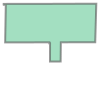

In [358]:
overlap.loc[686]['geometry_x']

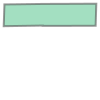

In [359]:
overlap.loc[853]['geometry_x']

Confirmed by using Maps that the VEST precincts are correct for these Maricopa ones ^. 

This is to check the VEST AZ file, vote totals and whether or not they match the data provided by MEDSL, regardless of whether we were able to match the particular precincts

In [360]:
#Checks the sums of different columns and prints out the 
def sum_checker (df1,df2, column_List):
    list_max = 0
    for i in column_List:
        df1_sum = df1[i].sum()
        df2_sum = df2[i].sum()
        if (df1_sum==df2_sum):
            print("Column: ", i, " have the same sums")
            
        else:
            diff = abs(df1_sum-df2_sum)
            percent = abs(df1_sum-df2_sum)/df1_sum
            print("Column: ", i)
            print("DataFrame #1 sum is ", str(df1_sum))
            print("DataFrame #2 sum is ", str(df2_sum))
            print("Their (absolute) difference is ",str(diff))
            print("As a percentage of DF1 this is ", str(round(percent*100,5)) + "%")
            if (percent>list_max):
                list_max = percent
            print("")
    print("The max difference (as a percent of the total of one DF column) is: ", str(round(list_max,5)))

In [361]:
sum_checker(df_joined,vest_shp,election_column_List)

Column:  G18USSRMCS  have the same sums
Column:  G18USSDSIN  have the same sums
Column:  G18USSGGRE  have the same sums
Column:  G18GOVRDUC  have the same sums
Column:  G18GOVDGAR  have the same sums
Column:  G18GOVGTOR  have the same sums
Column:  G18SOSRGAY  have the same sums
Column:  G18SOSDHOB  have the same sums
Column:  G18ATGRBRN  have the same sums
Column:  G18ATGDCON  have the same sums
Column:  G18TRERYEE  have the same sums
Column:  G18TREDMAN  have the same sums
Column:  G18SPIRRIG  have the same sums
Column:  G18SPIDHOF  have the same sums
Column:  G18MNIRHAR  have the same sums
Column:  G18MNIDPIE  have the same sums
The max difference (as a percent of the total of one DF column) is:  0


### Geometries

In [362]:
pdv_shapes_elections_and_shapes = gp.GeoDataFrame(overlap, geometry='geometry_x')
partner_shapes_elections_and_shapes = gp.GeoDataFrame(overlap, geometry='geometry_y')

pdv_shapes_elections_and_shapes.crs=partner_shapes_elections_and_shapes.crs

In [363]:
print(pdv_shapes_elections_and_shapes.geom_almost_equals(partner_shapes_elections_and_shapes,decimal=1).value_counts())

True     1487
False       2
dtype: int64


From the above, 1487 precincts match to one decimal and 2 differ.

In [364]:
pdv_shapes_elections_and_shapes['geom_almost_equals'] = \
    pdv_shapes_elections_and_shapes.geom_almost_equals(partner_shapes_elections_and_shapes,decimal=1)

Look at those 2 precincts that differ:

In [365]:
pdv_shapes_elections_and_shapes.loc[pdv_shapes_elections_and_shapes['geom_almost_equals'] == False]

,pctnum,precinctna,cde_county,geometry_x,county_name,county_precinct_x,matches,part1_temp_x,part2_temp_x,part3_temp,...,G18TREOWRI_y,G18SPIRRIG_y,G18SPIDHOF_y,G18SPIOWRI_y,G18MNIRHAR_y,G18MNIDPIE_y,G18MNIOWRI_y,geometry_y,_merge,geom_almost_equals
1487,LP0056,WENDEN,LP,"POLYGON ((-113.33383 33.90172, -113.33383 33.9...",La Paz,La Paz WENDEN,LA PAZ 6 WENDEN,La,Paz,WENDEN,...,2,67,28,2,69,24,2,"POLYGON ((-113.33337 33.99992, -113.33375 33.9...",both,False
1488,MC0614,SOUTH MTN PARK,MC,"POLYGON ((-112.10045 33.30506, -112.10160 33.3...",Maricopa,Maricopa SOUTH MTN PARK,MARICOPA 0614 SOUTH MTN PARK,Maricopa,SOUTH,MTN PARK,...,0,63,114,1,65,107,0,"POLYGON ((-111.99720 33.34877, -111.99720 33.3...",both,False


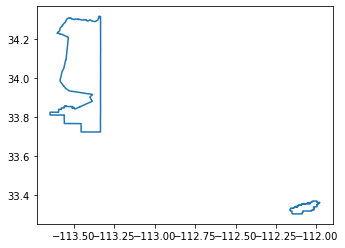

In [366]:
pdv_shapes_elections_and_shapes.loc[pdv_shapes_elections_and_shapes['geom_almost_equals'] == False].boundary.plot()

In [367]:
shp_difference = gp.overlay(pdv_shapes_elections_and_shapes, partner_shapes_elections_and_shapes, how='symmetric_difference')

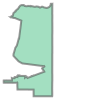

In [368]:
pdv_shapes_elections_and_shapes.loc[1487]['geometry_x']

In [369]:
pdv_shapes_elections_and_shapes.loc[1487]['geometry_x'].area

0.11498532951909986

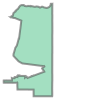

In [370]:
partner_shapes_elections_and_shapes.loc[1487]['geometry_y']

In [371]:
pdv_shapes_elections_and_shapes.loc[1487]['geometry_y'].area

0.11498532951909957

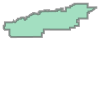

In [372]:
pdv_shapes_elections_and_shapes.loc[1488]['geometry_x']

In [373]:
pdv_shapes_elections_and_shapes.loc[1488]['geometry_x'].area

0.006179946114341157

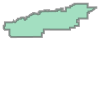

In [374]:
pdv_shapes_elections_and_shapes.loc[1488]['geometry_y']

In [375]:
pdv_shapes_elections_and_shapes.loc[1488]['geometry_y'].area

0.006179946114341162

The geography differences seem neglibile. 